# Import Libraries

In [8]:
from utils.preprocessing import load_preprocessed_data
from models.mlp import MLP, Trainer, ASLDataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Get Data

In [2]:
train_data = load_preprocessed_data('train')
val_data = load_preprocessed_data('val')
test_data = load_preprocessed_data('test')

# Train Models

## MLP

### Initialize Network

In [3]:
input_dim = train_data[0].shape[-1]
output_dim = len(np.unique(train_data[-1]))
model = MLP(input_dim=input_dim, output_dim=output_dim)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=29, bias=True)
  )
)


### Initialize Trainer

In [4]:
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    learning_rate=0.001,
    loss_fn=nn.CrossEntropyLoss(),
    dataset_cls=ASLDataset,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    batch_size=32,
    num_epochs=100,
    patience=3
)

### Train Model

In [5]:
history = trainer.train()

Epoch 1/100:


Val Loss: 1.4336, Val Acc: 0.4994: 100%|██████████| 435/435 [00:02<00:00, 190.88it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 2/100:


Val Loss: 0.9107, Val Acc: 0.6673: 100%|██████████| 435/435 [00:02<00:00, 202.56it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 3/100:


Val Loss: 0.9622, Val Acc: 0.6371: 100%|██████████| 435/435 [00:02<00:00, 199.40it/s]



Epoch 4/100:


Val Loss: 0.5526, Val Acc: 0.7927: 100%|██████████| 435/435 [00:02<00:00, 214.40it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 5/100:


Val Loss: 0.5066, Val Acc: 0.8121: 100%|██████████| 435/435 [00:02<00:00, 199.59it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 6/100:


Val Loss: 0.4014, Val Acc: 0.8540: 100%|██████████| 435/435 [00:02<00:00, 197.21it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 7/100:


Val Loss: 0.5035, Val Acc: 0.8121: 100%|██████████| 435/435 [00:02<00:00, 214.41it/s]



Epoch 8/100:


Val Loss: 0.3827, Val Acc: 0.8599: 100%|██████████| 435/435 [00:02<00:00, 199.26it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 9/100:


Val Loss: 0.3611, Val Acc: 0.8653: 100%|██████████| 435/435 [00:02<00:00, 185.52it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 10/100:


Val Loss: 0.4135, Val Acc: 0.8467: 100%|██████████| 435/435 [00:02<00:00, 194.31it/s]



Epoch 11/100:


Val Loss: 0.4103, Val Acc: 0.8541: 100%|██████████| 435/435 [00:02<00:00, 194.19it/s]



Epoch 12/100:


Val Loss: 0.2472, Val Acc: 0.9068: 100%|██████████| 435/435 [00:02<00:00, 191.62it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 13/100:


Val Loss: 0.4271, Val Acc: 0.8425: 100%|██████████| 435/435 [00:02<00:00, 199.20it/s]



Epoch 14/100:


Val Loss: 0.2367, Val Acc: 0.9112: 100%|██████████| 435/435 [00:02<00:00, 210.28it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 15/100:


Val Loss: 0.3570, Val Acc: 0.8790: 100%|██████████| 435/435 [00:02<00:00, 207.86it/s]



Epoch 16/100:


Val Loss: 0.3523, Val Acc: 0.8759: 100%|██████████| 435/435 [00:02<00:00, 210.94it/s]



Epoch 17/100:


Val Loss: 0.3477, Val Acc: 0.8782: 100%|██████████| 435/435 [00:02<00:00, 211.55it/s]


Early stopping triggered at epoch 17.
Restoring weights back to epoch 14.


### Visualize Training

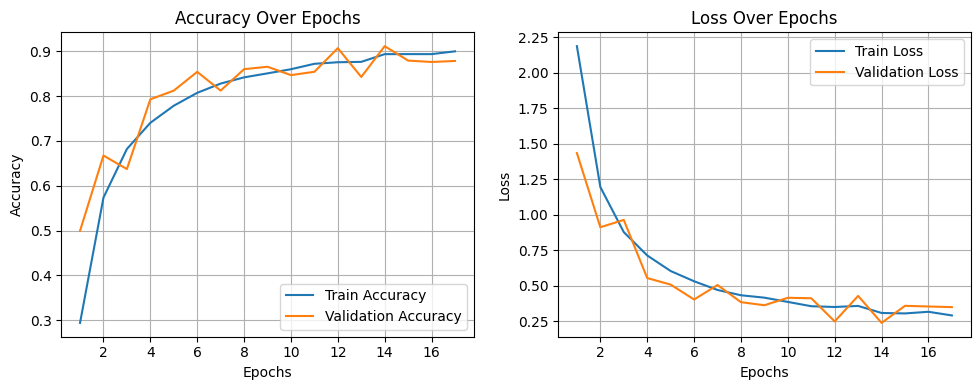

In [9]:
# Extracting data
train_acc = history['train']['accuracy']
train_loss = history['train']['loss']
val_acc = history['validation']['accuracy']
val_loss = history['validation']['loss']
epochs = range(1, len(train_acc) + 1)

# Plotting accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Evalaute Model on Test Set

In [6]:
_ = trainer.evaluate(loader_type='test')

Test Loss: 0.2389, Test Acc: 0.9114: 100%|██████████| 544/544 [00:02<00:00, 199.72it/s]
